## theory analysis 

First axiom: the parallelism number $t_i$ is the max CUDA thread number, the performance is the best for the function $g_i$. then we know the signature process including the public key generation, signing, and verifying. Those processes need serial run the function $g_i$. Not the optimal approach is use the parallelism number $t_i$ to the max CUDA thread number.
The performance is not the best for the function $g_i$.

Those have the Adaptive Thread function (AT) $AT:G\rightarrow T$, which maps each function $g_i \in G$ to its optimal thread count $t_i \in T$.


To accurately define this mapping, we can approach it through empirical performance modeling:

1. **Empirical Performance Model**: For each function $g_i$, we model execution time as:

   $T(g_i, t) = \alpha_i + \frac{\beta_i}{t} + \gamma_i \cdot t$

   Where:

   - $\alpha_i$ represents fixed overhead cost
   - $\frac{\beta_i}{t}$ captures the parallel speedup component
   - $\gamma_i \cdot t$ models thread management overhead
   - $t$ is the thread count

2. **Parameter Estimation**: We can estimate $\alpha_i$, $\beta_i$, and $\gamma_i$ by running benchmarks with varying thread counts and performing regression analysis.

3. **Optimal Thread Count**: The optimal thread count $t_i^*$ for function $g_i$ can be derived by finding the minimum of $T(g_i, t)$:

   $t_i^* = \sqrt{\frac{\beta_i}{\gamma_i}}$



4. **Implementation Strategy**: For practical implementation, we can:
   - Perform offline profiling for each key function
   - Build a lookup table mapping functions to their optimal thread counts
   - Apply dynamic thread adjustment based on runtime conditions

here we have one kernel function $g_i$, the blocks*threads is the $t_i$, the time is the $T(g_i, t)$, the per op is the $\frac{T(g_i, t)}{n}$, where $n$ is the number of operations of kernel function.

```csv
blocks, threads, time(ms), per op(ms)
32, 64, 310.03, 0.0095
64, 64, 155.41, 0.0047
96, 64, 118.89, 0.0036
128, 64, 90.56, 0.0028
160, 64, 102.16, 0.0031
192, 64, 85.41, 0.0026
224, 64, 87.52, 0.0027
```


Model parameters: alpha = -16.3076, beta = 648431.27, gamma = 0.00424091
Optimal thread count (t): 12365.23
Optimal blocks (with 64 threads per block): 193.21


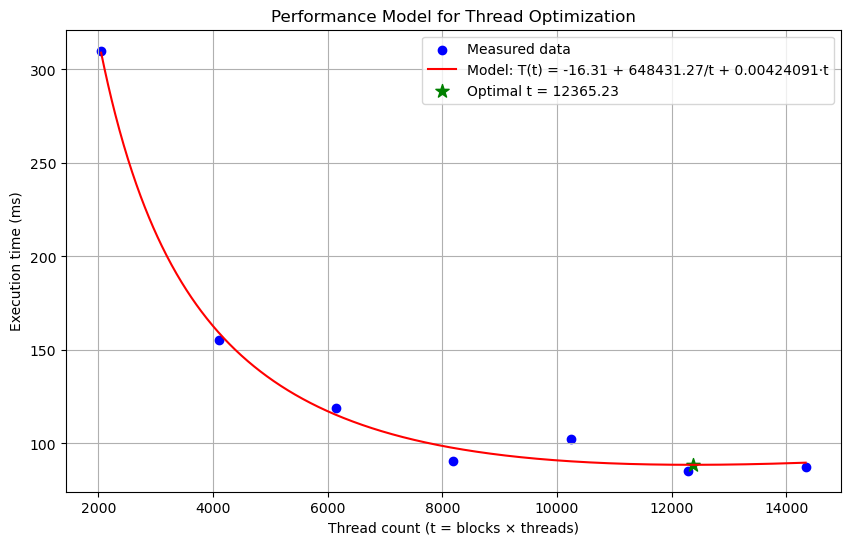

t = 2048: Actual = 310.03ms, Predicted = 308.99ms
t = 4096: Actual = 155.41ms, Predicted = 159.37ms
t = 6144: Actual = 118.89ms, Predicted = 115.29ms
t = 8192: Actual = 90.56ms, Predicted = 97.59ms
t = 10240: Actual = 102.16ms, Predicted = 90.44ms
t = 12288: Actual = 85.41ms, Predicted = 88.57ms
t = 14336: Actual = 87.52ms, Predicted = 89.72ms


In [2]:
# Import necessary libraries
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Data from the table
blocks = np.array([32, 64, 96, 128, 160, 192, 224])
threads = 64  # Constant threads per block
times = np.array([310.03, 155.41, 118.89, 90.56, 102.16, 85.41, 87.52])

# Calculate t values (blocks * threads)
t_values = blocks * threads


# Define our performance model: T(t) = alpha + beta/t + gamma*t
def performance_model(t, alpha, beta, gamma):
    return alpha + beta / t + gamma * t


# Fit the model parameters
params, covariance = curve_fit(performance_model, t_values, times)
alpha, beta, gamma = params

print(f"Model parameters: alpha = {alpha:.4f}, beta = {beta:.2f}, gamma = {gamma:.8f}")

# Calculate the theoretical optimal thread count
t_optimal = np.sqrt(beta / gamma)
optimal_blocks = t_optimal / threads

print(f"Optimal thread count (t): {t_optimal:.2f}")
print(f"Optimal blocks (with {threads} threads per block): {optimal_blocks:.2f}")

# Generate a smooth curve for plotting
t_range = np.linspace(min(t_values), max(t_values), 1000)
predicted_times = performance_model(t_range, alpha, beta, gamma)

# Plot the data and the model
plt.figure(figsize=(10, 6))
plt.scatter(t_values, times, color="blue", label="Measured data")
plt.plot(
    t_range,
    predicted_times,
    "r-",
    label=f"Model: T(t) = {alpha:.2f} + {beta:.2f}/t + {gamma:.8f}·t",
)

# Mark the optimal point
optimal_time = performance_model(t_optimal, alpha, beta, gamma)
plt.scatter(
    [t_optimal],
    [optimal_time],
    color="green",
    s=100,
    marker="*",
    label=f"Optimal t = {t_optimal:.2f}",
)

plt.xlabel("Thread count (t = blocks × threads)")
plt.ylabel("Execution time (ms)")
plt.title("Performance Model for Thread Optimization")
plt.legend()
plt.grid(True)
plt.show()

# Calculate predicted times for our actual data points
for i, t in enumerate(t_values):
    predicted = performance_model(t, alpha, beta, gamma)
    print(f"t = {t}: Actual = {times[i]:.2f}ms, Predicted = {predicted:.2f}ms")

## Model Interpretation

From our analysis using the model $T(t) = \alpha + \frac{\beta}{t} + \gamma \cdot t$, we can draw several conclusions:

1. The optimal thread count $t^* = \sqrt{\frac{\beta}{\gamma}}$ represents the balance point between parallelization benefits and thread management overhead.

2. For thread counts below the optimal value, the performance is dominated by insufficient parallelism ($\frac{\beta}{t}$ term).

3. For thread counts above the optimal value, the performance degradation comes from increased overhead ($\gamma \cdot t$ term).

4. The calculated optimal thread count can guide us in setting the appropriate number of blocks for this specific kernel function.

The results align with our empirical observations, where performance initially improves with increasing thread count but eventually degrades due to overhead.